# Perfume Information Retrieval Chatbot Recommendations

In [15]:
import pandas as pd
import numpy as np
import pickle
from textwrap import wrap
import re

import matplotlib.pyplot as plt
from skimage import io

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

from gensim.models.doc2vec import Doc2Vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy import sparse


class Perfume_Information_Retrieval_Model():
    
    def __init__(self):
        self.dv = Doc2Vec.load("./models/doc2vec_model")
        self.tf = pickle.load(open("models/tfidf_model.pkl", "rb"))
        self.svd = pickle.load(open("models/svd_model.pkl", "rb"))
        self.svd_feature_matrix = pickle.load(open("models/lsa_embeddings.pkl", "rb"))
        self.doctovec_feature_matrix = pickle.load(open("models/doctovec_embeddings.pkl", "rb"))
        self.df = df = pd.read_pickle("data/perfume_data.pkl")
        self.hal = sia()
        
        
    @staticmethod    
    def stem_words(text):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        return text

    
    @staticmethod
    def make_lower_case(text):
        return text.lower()

    
    @staticmethod
    def remove_stop_words(text):
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        return text

    
    @staticmethod
    def remove_punctuation(text):
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        text = " ".join(text)
        return text


    def get_message_sentiment(self, message):
        sentences = re.split('\.|\but',message)
        sentences = [x for x in sentences if x != ""]
        love_message = ""
        hate_message = ""
        for s in sentences:
            sentiment_scores = self.hal.polarity_scores(s)
            if sentiment_scores['neg'] > 0:
                hate_message = hate_message + s
            else:
                love_message = love_message + s
        return love_message, hate_message

    
    def clean_message(self, message):
        message = self.make_lower_case(message)
        message = self.remove_stop_words(message)
        message = self.remove_punctuation(message)
        message = self.stem_words(message)
        return message


    def get_message_tfidf_embedding_vector(self, message):
        message_array = self.tf.transform([message]).toarray()
        message_array = self.svd.transform(message_array)
        message_array = message_array[:,0:25].reshape(1, -1)
        return message_array


    def get_message_doctovec_embedding_vector(self, message):
        message_array = self.dv.infer_vector(doc_words=message.split(" "), epochs=200)
        message_array = message_array.reshape(1, -1)
        return message_array

    
    @staticmethod
    def get_similarity_scores(message_array, embeddings):
        cosine_sim_matrix = pd.DataFrame(cosine_similarity(X=embeddings,
                                                           Y=message_array,
                                                           dense_output=True))
        cosine_sim_matrix.set_index(embeddings.index, inplace=True)
        cosine_sim_matrix.columns = ["cosine_similarity"]
        return cosine_sim_matrix

    
    def get_ensemble_similarity_scores(self, message):
        message = self.clean_message(message)
        bow_message_array = self.get_message_tfidf_embedding_vector(message)
        semantic_message_array = self.get_message_doctovec_embedding_vector(message)

        bow_similarity = self.get_similarity_scores(bow_message_array, self.svd_feature_matrix)
        semantic_similarity = self.get_similarity_scores(semantic_message_array, self.doctovec_feature_matrix)

        ensemble_similarity = pd.merge(semantic_similarity, bow_similarity, left_index=True, right_index=True)
        ensemble_similarity.columns = ["semantic_similarity", "bow_similarity"]
        ensemble_similarity['ensemble_similarity'] = (ensemble_similarity["semantic_similarity"] + ensemble_similarity["bow_similarity"])/2
        ensemble_similarity.sort_values(by="ensemble_similarity", ascending=False, inplace=True)
        return ensemble_similarity

    
    def get_dissimilarity_scores(self, message):
        message = self.clean_message(message)
        bow_message_array = self.get_message_tfidf_embedding_vector(message)
        semantic_message_array = self.get_message_doctovec_embedding_vector(message)

        dissimilarity = self.get_similarity_scores(bow_message_array, self.svd_feature_matrix)
        dissimilarity.columns = ["dissimilarity"]
        dissimilarity.sort_values(by="dissimilarity", ascending=False, inplace=True)
        return dissimilarity
   

    def query_similar_perfumes(self, message, n):
        
        love_message, hate_message = self.get_message_sentiment(message)
    
        similar_perfumes = self.get_ensemble_similarity_scores(love_message)
        dissimilar_perfumes = self.get_dissimilarity_scores(hate_message)
        dissimilar_perfumes = dissimilar_perfumes.query('dissimilarity > .3')
        similar_perfumes = similar_perfumes.drop(dissimilar_perfumes.index)

        return similar_perfumes.head(n)
    
    def view_recommendations(self, recs):
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10))
        ax = axes.ravel()
        
        for i in range(len(recs)):
            single_title = recs.index.tolist()[i]
            single_perfume = self.df.query('title==@single_title')
            name = single_perfume.title.values[0]
            notes = single_perfume.notes.values[0]
            title = "{} \n Notes: {}".format(name, notes)

            perfume_image = single_perfume.image_url.values[0]
            image = io.imread(perfume_image)
            ax[i].imshow(image)
            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])
            ax[i].set_title("\n".join(wrap(title, 20)))
            ax[i].axis('off')

        plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/clairelongo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairelongo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
pir = Perfume_Information_Retrieval_Model()

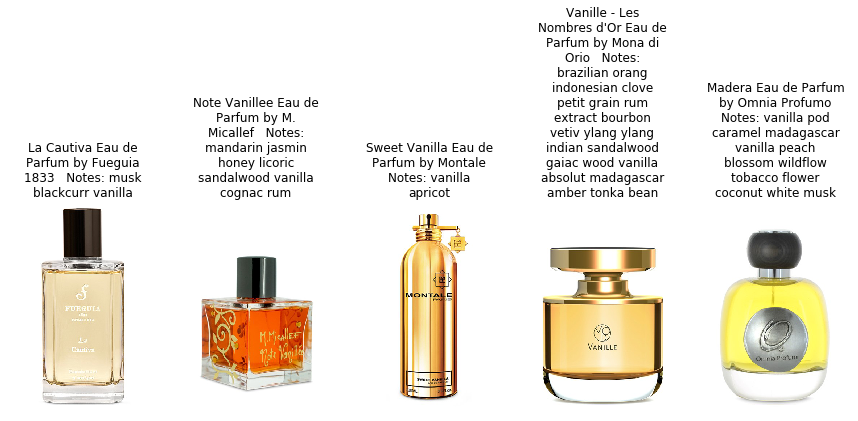

In [17]:
message = "I like peaches and pears. Boozy vanilla and sweet smelling gourmands."
recs = pir.query_similar_perfumes(message, 5)
pir.view_recommendations(recs)

In [ ]:
message = "I like peaches and pears. Boozy vanilla and sweet smelling gourmands. I don't like tobacco, or coconut."
recs = pir.query_similar_perfumes(message, 5)
pir.view_recommendations(recs)